<a href="https://colab.research.google.com/github/shreyasrajesh0308/ECE188DeepLearning/blob/main/Adv_example_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perform an Adversarial attack.

For the second part of the project we consider a trained model (MobileNet) which is trained on the imagenet dataset. 

We use an evasion attack called [FGSM](https://neptune.ai/blog/adversarial-attacks-on-neural-networks-exploring-the-fast-gradient-sign-method#:~:text=The%20Fast%20Gradient%20Sign%20Method%20(FGSM)%20combines%20a%20white%20box,model%20into%20making%20wrong%20predictions.) to fool the neural network into making incorrect predictions.

## Import Packages.

Import the necessary packages we continue to use Tensorflow and Keras

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing import image

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

## Load the Pretrained model. 

We use the [MobileNetV2](https://arxiv.org/abs/1801.04381) model trained on the [Imagenet](https://www.image-net.org/) dataset. 

In [2]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14548992/14536120 [==============================] - 0s 0us/step


### Helper Function for Data Processing


Following functions can be used for data processing. Dont worry about these, just use them. 

In [3]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Load an Image. 


Load any image, we consider an image of a Golden Retriever. 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
image_raw = tf.io.read_file('/content/drive/MyDrive/ucla course/ECE188/little_panda.jpeg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

49152/35363 [=========================================] - 0s 0us/step


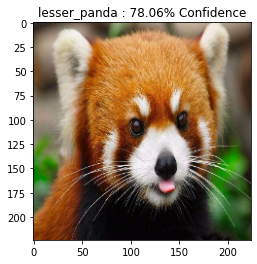

In [6]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the Adversarial Image. 

We use the FGSM method to create an adversarial image. Be sure to read about FGSM to understand how the attack works. 

In [7]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

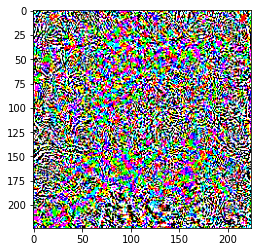

In [8]:
# Get the input label of the image.
giant_panda_index = 388
label = tf.one_hot(giant_panda_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [9]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

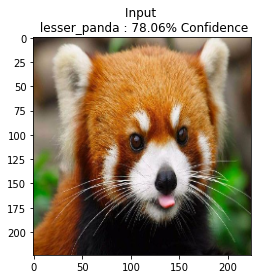

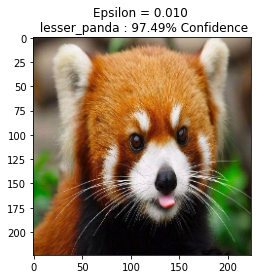

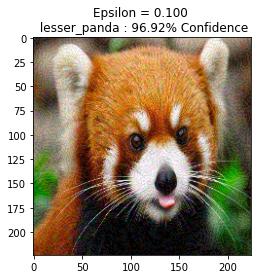

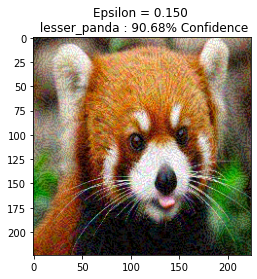

In [10]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

# Task2: Perform an Analysis to understand the potency of the attack. 

Your task here is to understand how small a change could change the class output and this is measured by the epsilon value needed to change the class. 

Your task is as follows:

* Pick 10 images each from different classes in imagenet. 
* Perform a perturbation analysis on each of these images. 
* In the analysis you are required to report the smallest epsilon value for which you notice a class change. 
* Make a table for each of the images considered with the minimum epsilon value for the FGSM attack. 

Write the Code for the above below. You can add the table also below. 

In [11]:
def display_images_labeled(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()
  return label

['n02823428_beer_bottle.JPEG', 'n04146614_school_bus.JPEG', 'n02342885_hamster.JPEG', 'n02109961_Eskimo_dog.JPEG', 'n02782093_balloon.JPEG', 'n01443537_goldfish.JPEG', 'n02835271_bicycle-built-for-two.JPEG', 'n02974003_car_wheel.JPEG', 'n02669723_academic_gown.JPEG', 'n01484850_great_white_shark.JPEG']
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(10, 224, 224, 3)


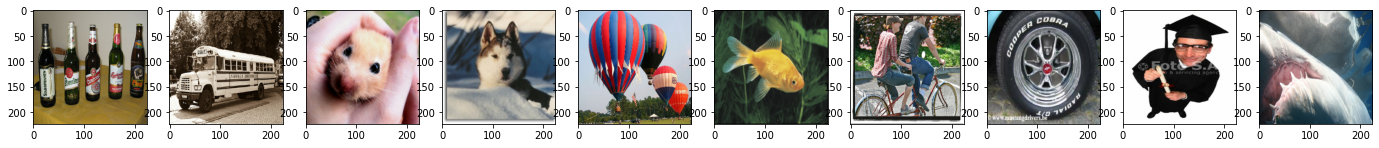

In [12]:
import os
import numpy as np
imagesnames = os.listdir('/content/drive/MyDrive/ucla course/ECE188/imagnet')
print(imagesnames)
images = []
shownimages = []
for eachimagename in imagesnames:
  image_raw = tf.io.read_file(os.path.join('/content/drive/MyDrive/ucla course/ECE188/imagnet', eachimagename))
  image = tf.image.decode_image(image_raw)
  image = preprocess(image)
  images.append(image[0])
  print(image[0].shape)
print(np.shape(images))
_, axs = plt.subplots(1, 10, figsize=(24, 24))
axs = axs.flatten()
for img, ax in zip(images, axs):
    ax.imshow(img*0.5+0.5)
plt.show()

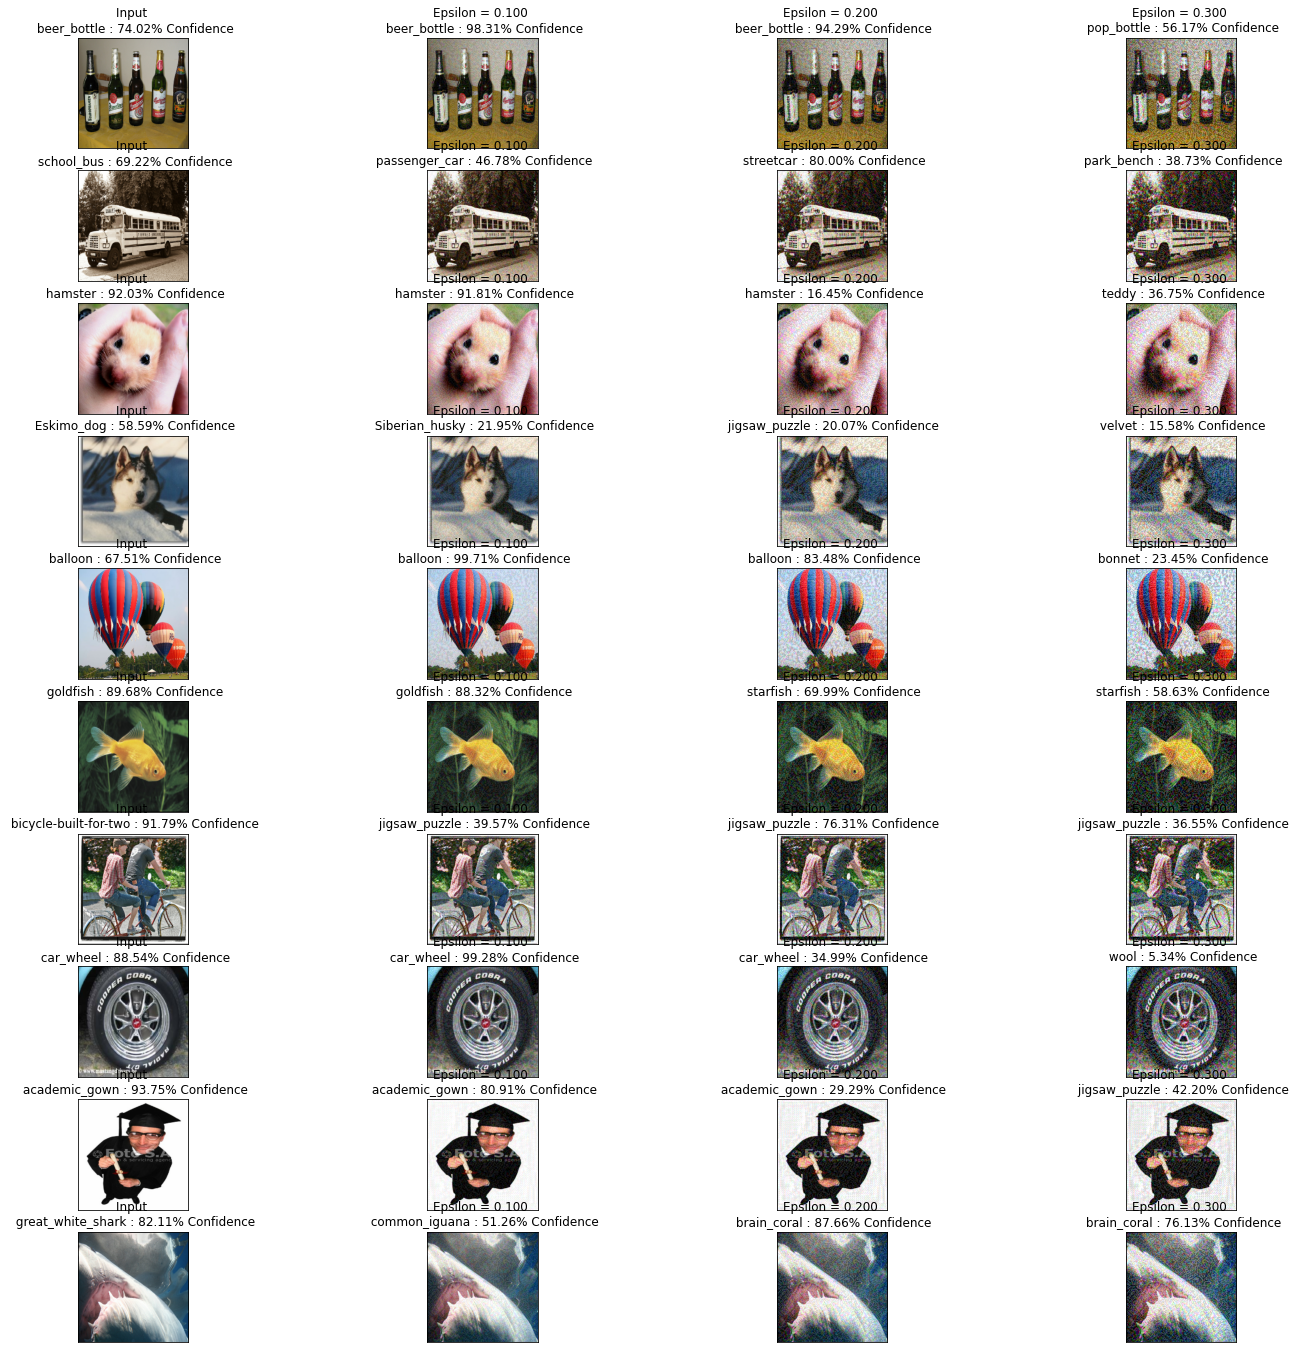

In [13]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
display_images = []
display_title = []
classes = []
for eachimage in images:
  giant_panda_index = 388
  label = tf.one_hot(giant_panda_index, image_probs.shape[-1])
  label = tf.reshape(label, (1, image_probs.shape[-1]))

  perturbations = create_adversarial_pattern(eachimage.reshape(1,224,224,3), label)
  epsilons = [0, 0.1, 0.2, 0.3]
  descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                  for eps in epsilons]
  for i, eps in enumerate(epsilons):
    adv_x = eachimage + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    _, label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))
    if i == 0:
      classes.append(label)
    display_images.append(adv_x[0])
    display_title.append('{} \n {} : {:.2f}% Confidence'.format(descriptions[i],
                                                    label, confidence*100))
_, axs = plt.subplots(10, 4, figsize=(24, 24))
axs = axs.flatten()
img_titles = zip(display_images,display_title)
for img_titles, ax in zip(img_titles, axs):
    img, title = img_titles
    ax.imshow(img*0.5+0.5)
    ax.set_title(title)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
plt.show()

In [14]:
print(classes)

['beer_bottle', 'school_bus', 'hamster', 'Eskimo_dog', 'balloon', 'goldfish', 'bicycle-built-for-two', 'car_wheel', 'academic_gown', 'great_white_shark']


In [15]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
change_threshold = []
changed_to = []
for eachimage, truelabel in zip(images,classes):
  giant_panda_index = 388
  label = tf.one_hot(giant_panda_index, image_probs.shape[-1])
  label = tf.reshape(label, (1, image_probs.shape[-1]))

  perturbations = create_adversarial_pattern(eachimage.reshape(1,224,224,3), label)
  epsilons = [0, 0.1, 0.2, 0.3]
  descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                  for eps in epsilons]
  eps = 0
  while(True):
    adv_x = eachimage + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    _, label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))
    if label != truelabel:
      change_threshold.append(eps)
      changed_to.append(label)
      break
    else:
      eps += 0.01
from_tos = zip(classes,changed_to)
for from_to, eachthresh in zip(from_tos,change_threshold):
  eachclass, toclass = from_to
  print("class: " + str(eachclass) + " changed to: "+ str(toclass) +" with eps: " + str(eachthresh))

class: beer_bottle changed to: pop_bottle with eps: 0.26000000000000006
class: school_bus changed to: passenger_car with eps: 0.060000000000000005
class: hamster changed to: teddy with eps: 0.22000000000000006
class: Eskimo_dog changed to: Siberian_husky with eps: 0.09
class: balloon changed to: bonnet with eps: 0.2900000000000001
class: goldfish changed to: starfish with eps: 0.16
class: bicycle-built-for-two changed to: jigsaw_puzzle with eps: 0.05
class: car_wheel changed to: coil with eps: 0.24000000000000007
class: academic_gown changed to: mortarboard with eps: 0.21000000000000005
class: great_white_shark changed to: dugong with eps: 0.04


# Task3: Compare the robustness of the considered model with other models. 

Your task here is to compare how this model (MobileNetV2) compares with other popular object detection models. 

Your task is as follows:

* Consider 5 different models (you can consider various RESNET architectures, any models you find interesting).
* Load the pre-trained weights of the model (trained on imagenet). 
* Perform Task2 on all the considered models. 
* Add all the results in the table. Hence the final table you have 6 columns for each model and epsilon values for each of the 10 images for all 6 models. 


What do you observe? Why do you think this is the case? 

Write the Code for the above below. You can also add the table and answer to the question below. 


I notice that for the later more-advanced archetecture or model with greater parameters such as denseNET and NASNet, the eps needed to do the attacks are much greater. This probably means that these models are more "attack-proofing" than other models.

In [16]:
pretrained_model1 = tf.keras.applications.ResNet152V2(include_top=True,
                                                     weights='imagenet')
pretrained_model1.trainable = False
preprocess1 = tf.keras.applications.resnet_v2.preprocess_input


pretrained_model2 = tf.keras.applications.Xception(include_top=True,
                                                     weights='imagenet')
pretrained_model2.trainable = False
preprocess2 = tf.keras.applications.xception.preprocess_input

pretrained_model3 = tf.keras.applications.MobileNet(include_top=True,weights='imagenet')
pretrained_model3.trainable = False
preprocess3 = tf.keras.applications.mobilenet.preprocess_input


pretrained_model4 = tf.keras.applications.DenseNet201(include_top=True,
                                                     weights='imagenet')
pretrained_model4.trainable = False
preprocess4 = tf.keras.applications.densenet.preprocess_input


pretrained_model5 = tf.keras.applications.NASNetLarge(include_top=True,
                                                     weights='imagenet')
pretrained_model5.trainable = False
preprocess5 = tf.keras.applications.nasnet.preprocess_input

359759872/359748576 [==============================] - 2s 0us/step


In [17]:
def preprocess_model(image, preprocess, size):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, size)
  image = preprocess(image)
  image = image[None, ...]
  return image
def create_adversarial_pattern_model(input_image, input_label, model):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [18]:
models = [pretrained_model1, pretrained_model2, pretrained_model3, 
          pretrained_model4, pretrained_model5]
preprocesses = [preprocess1, preprocess2, preprocess3, preprocess4, preprocess5]
resize = {'resnet152v2': (224,224), 'xception': (299,299), 
           'mobilenet_1.00_224': (224,224), 'densenet201': (224,224),
           'NASNet': (331,331)}
for model,preprocess in zip(models,preprocesses):
  print(model.name + "=============================")
  images = []
  shownimages = []
  for eachimagename in imagesnames:
    image_raw = tf.io.read_file(os.path.join('/content/drive/MyDrive/ucla course/ECE188/imagnet', eachimagename))
    image = tf.image.decode_image(image_raw)
    image = preprocess_model(image,preprocess,resize[model.name])
    images.append(image[0])
  change_threshold = []
  changed_to = []
  for eachimage, truelabel in zip(images,classes):
    giant_panda_index = 388
    label = tf.one_hot(giant_panda_index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))

    perturbations = create_adversarial_pattern_model(eachimage.reshape(1,resize[model.name][0],resize[model.name][1],3), label, model)
    epsilons = [0, 0.1, 0.2, 0.3]
    descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                    for eps in epsilons]
    eps = 0
    while(True):
      adv_x = eachimage + eps*perturbations
      adv_x = tf.clip_by_value(adv_x, -1, 1)
      _, label, confidence = get_imagenet_label(model.predict(adv_x))
      if label != truelabel:
        change_threshold.append(eps)
        changed_to.append(label)
        break
      else:
        eps += 0.01
  from_tos = zip(classes,changed_to)
  for from_to, eachthresh in zip(from_tos,change_threshold):
    eachclass, toclass = from_to
    print("class: " + str(eachclass) + " changed to: "+ str(toclass) +" with eps: " + str(eachthresh))

resnet152v2=============================
class: beer_bottle changed to: sock with eps: 0.46000000000000024
class: school_bus changed to: jigsaw_puzzle with eps: 0.5900000000000003
class: hamster changed to: West_Highland_white_terrier with eps: 0.11999999999999998
class: Eskimo_dog changed to: Siberian_husky with eps: 0
class: balloon changed to: jigsaw_puzzle with eps: 0.23000000000000007
class: goldfish changed to: starfish with eps: 0.3300000000000001
class: bicycle-built-for-two changed to: jigsaw_puzzle with eps: 0.23000000000000007
class: car_wheel changed to: wall_clock with eps: 0.4400000000000002
class: academic_gown changed to: mortarboard with eps: 0.01
class: great_white_shark changed to: dugong with eps: 0.3300000000000001
xception=============================
class: beer_bottle changed to: punching_bag with eps: 0.5400000000000003
class: school_bus changed to: recreational_vehicle with eps: 0.48000000000000026
class: hamster changed to: toy_poodle with eps: 0.450000000000

| Class/Model           | Mobilenet-v2 | resnet152v2 | xception | mobilenet-v1 | densenet201 | NASNet | mobilenet-v2 with momentum |
|-----------------------|--------------|-------------|----------|--------------|-------------|--------|----------------------------|
| beer_bottle           | 0.26         | 0.46        | 0.54     | 0.37         | 1.14        | 0.86   | 0.29                       |
| school_bus            | 0.06         | 0.59        | 0.48     | 0.45         | 1.25        | 1.12   | 0.06                       |
| hamaster              | 0.22         | 0.12        | 0.45     | 0.29         | 0.28        | 0.54   | 0.119                      |
| Eskimo_dog            | 0.09         | 0           | 0.02     | 0.07         | 0.51        | 0.03   | 0.07                       |
| balloon               | 0.29         | 0.23        | 0.53     | 0.46         | 0.69        | 1.08   | 0.3                        |
| goldfish              | 0.16         | 0.33        | 0.38     | 0.28         | 0.37        | 0.47   | 0.22                       |
| bicycle-built-for-two | 0.05         | 0.23        | 0.27     | 0.24         | 0.56        | 0.83   | 0.17                       |
| car_wheel             | 0.24         | 0.44        | 0.6      | 0.33         | 0.93        | 0.68   | 0.29                       |
| academic_gown         | 0.21         | 0.01        | 0.19     | 0.08         | 0.23        | 0.24   | 0.16                       |
| great_white_shark     | 0.04         | 0.33        | 0.07     | 0.06         | 0.42        | 0.06   | 0.03                       |


# BONUS: Can you provide a better attack?

Can you design a better attack that lowers the epsilon required for the images?

Task:

* Design another attack. 
* Compare the epsilon values on 10 images. 
* Does it perform better than the FGSM attack? That is, does it have lower epsilon values?

Write the code and provide your answers below. 

Note: The following implementation of momentum FGSM are referenced from: https://github.com/Harry24k/adversarial-attacks-pytorch

In [19]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
def create_adversarial_pattern_momentum(input_image, input_label, step, eps):
  clone_input_label = tf.identity(input_label)
  adv_x = tf.identity(input_image)
  momentum = tf.zeros_like(adv_x)
  signed_grad = None
  for _ in range(step):
    with tf.GradientTape() as tape:
      tape.watch(adv_x)
      prediction = pretrained_model(adv_x)
      loss = loss_object(clone_input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, adv_x)
    # Get the sign of the gradients to create the perturbation
    gradient = gradient / tf.math.reduce_mean(tf.abs(gradient), axis=[0,1,2], keepdims=True)
    gradient = gradient + momentum * 0.05
    momentum = gradient
    perturbations = tf.sign(gradient)
    adv_x = adv_x + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
  signed_grad = tf.sign(gradient)
  return signed_grad 
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [20]:
import os
import numpy as np
imagesnames = os.listdir('/content/drive/MyDrive/ucla course/ECE188/imagnet')
print(imagesnames)
images = []
shownimages = []
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image
for eachimagename in imagesnames:
  image_raw = tf.io.read_file(os.path.join('/content/drive/MyDrive/ucla course/ECE188/imagnet', eachimagename))
  image = tf.image.decode_image(image_raw)
  image = preprocess(image)
  images.append(image)
for eachimage in images:
  giant_panda_index = 388
  # print(label)

  epsilons = [0, 0.1, 0.2, 0.3]
  descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                  for eps in epsilons]
  for i, eps in enumerate(epsilons):
    # print(i)
    label = tf.one_hot(giant_panda_index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))
    perturbations = create_adversarial_pattern_momentum(eachimage.reshape(1,224,224,3), label, step=10, eps=eps)
    adv_x = eachimage + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    _, label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))
    if i == 0:
      classes.append(label)
    display_images.append(adv_x[0])
    display_title.append('{} \n {} : {:.2f}% Confidence'.format(descriptions[i],
                                                    label, confidence*100))

['n02823428_beer_bottle.JPEG', 'n04146614_school_bus.JPEG', 'n02342885_hamster.JPEG', 'n02109961_Eskimo_dog.JPEG', 'n02782093_balloon.JPEG', 'n01443537_goldfish.JPEG', 'n02835271_bicycle-built-for-two.JPEG', 'n02974003_car_wheel.JPEG', 'n02669723_academic_gown.JPEG', 'n01484850_great_white_shark.JPEG']


In [21]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
change_threshold = []
changed_to = []
for eachimage, truelabel in zip(images,classes):
  giant_panda_index = 388
  label = tf.one_hot(giant_panda_index, image_probs.shape[-1])
  label = tf.reshape(label, (1, image_probs.shape[-1]))
  eps = 0
  while(True):
    label = tf.one_hot(giant_panda_index, image_probs.shape[-1])
    label = tf.reshape(label, (1, image_probs.shape[-1]))
    perturbations = create_adversarial_pattern_momentum(eachimage.reshape(1,224,224,3), label, step=5, eps=eps)
    adv_x = eachimage + eps * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    _, label, confidence = get_imagenet_label(pretrained_model.predict(adv_x))
    if label != truelabel:
      change_threshold.append(eps)
      changed_to.append(label)
      break
    else:
      eps += 0.01
from_tos = zip(classes,changed_to)
for from_to, eachthresh in zip(from_tos,change_threshold):
  eachclass, toclass = from_to
  print("class: " + str(eachclass) + " changed to: "+ str(toclass) +" with eps: " + str(eachthresh))

class: beer_bottle changed to: pop_bottle with eps: 0.2900000000000001
class: school_bus changed to: passenger_car with eps: 0.060000000000000005
class: hamster changed to: golden_retriever with eps: 0.11999999999999998
class: Eskimo_dog changed to: Siberian_husky with eps: 0.07
class: balloon changed to: maze with eps: 0.3000000000000001
class: goldfish changed to: loggerhead with eps: 0.22000000000000006
class: bicycle-built-for-two changed to: jigsaw_puzzle with eps: 0.17
class: car_wheel changed to: coil with eps: 0.2900000000000001
class: academic_gown changed to: mortarboard with eps: 0.16
class: great_white_shark changed to: hippopotamus with eps: 0.03


| Class/Model           | Mobilenet-v2 | resnet152v2 | xception | mobilenet-v1 | densenet201 | NASNet | mobilenet-v2 with momentum |
|-----------------------|--------------|-------------|----------|--------------|-------------|--------|----------------------------|
| beer_bottle           | 0.26         | 0.46        | 0.54     | 0.37         | 1.14        | 0.86   | 0.29                       |
| school_bus            | 0.06         | 0.59        | 0.48     | 0.45         | 1.25        | 1.12   | 0.06                       |
| hamaster              | 0.22         | 0.12        | 0.45     | 0.29         | 0.28        | 0.54   | 0.119                      |
| Eskimo_dog            | 0.09         | 0           | 0.02     | 0.07         | 0.51        | 0.03   | 0.07                       |
| balloon               | 0.29         | 0.23        | 0.53     | 0.46         | 0.69        | 1.08   | 0.3                        |
| goldfish              | 0.16         | 0.33        | 0.38     | 0.28         | 0.37        | 0.47   | 0.22                       |
| bicycle-built-for-two | 0.05         | 0.23        | 0.27     | 0.24         | 0.56        | 0.83   | 0.17                       |
| car_wheel             | 0.24         | 0.44        | 0.6      | 0.33         | 0.93        | 0.68   | 0.29                       |
| academic_gown         | 0.21         | 0.01        | 0.19     | 0.08         | 0.23        | 0.24   | 0.16                       |
| great_white_shark     | 0.04         | 0.33        | 0.07     | 0.06         | 0.42        | 0.06   | 0.03                       |


Analysis: I use the momentum idea from the traiditional gradient descent to improve the attacks. The pertubation generation incluile des n steps of optimization. However, as the result shows, it performs better on some class, while worse on other class. I think to have better performance, I need to fine-tuning the parameters such as decay-rate and steps.